# Stroke Prediction System - Test Cases

This notebook provides comprehensive testing for the stroke prediction models. It allows you to verify that your models are loading correctly and making reasonable predictions without running the full Flask application.

## Contents
1. Setup and Imports
2. Model Loading Tests
3. Basic Prediction Tests
4. Visualization Tests
5. Edge Cases and Error Handling
6. Performance Analysis

## 1. Setup and Imports

Import the necessary libraries and configure the environment.

In [50]:
import torch
import torch.nn as nn
from torchvision import models
import timm  # For EfficientNet
import cv2  # Add this import for OpenCV

class StrokeCTModel(nn.Module):
    """CNN model for stroke detection"""
    def __init__(self, base_model_name, input_shape=(256, 256, 3), num_classes=2):
        super(StrokeCTModel, self).__init__()
        self.model_name = base_model_name.lower()
        
        # Initialize the base model
        if self.model_name == 'densenet121':
            self.base_model = models.densenet121(weights='IMAGENET1K_V1')
            num_features = self.base_model.classifier.in_features
            self.base_model.classifier = nn.Identity()
            
        elif self.model_name == 'resnet50':
            self.base_model = models.resnet50(weights='IMAGENET1K_V1')
            num_features = self.base_model.fc.in_features
            self.base_model.fc = nn.Identity()
            
        elif self.model_name == 'efficientnet':
            # Use timm for efficientnet models
            self.base_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
            num_features = self.base_model.num_features
            
        else:
            raise ValueError(f"Unknown base model: {base_model_name}")
        
        # Add custom layers
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

In [51]:
import os
import sys
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
import time
import logging
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("StrokePredictionTests")

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
GPU memory: 4.29 GB


## Define the Model Loader Class

We'll use a simplified version of the model loader class from the Flask application.

In [52]:
class StrokeModelLoader:
    """Utility class for loading and working with trained stroke prediction models."""
    
    def __init__(self, models_dir='models_pytorch', use_best=False):
        """Initialize the model loader."""
        self.models_dir = models_dir
        self.use_best = use_best
        self.device = device
        
        # Model names
        self.model_names = ['densenet121', 'resnet50', 'efficientnet']
        
        # Transforms for preprocessing images
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        # Check if models directory exists
        if not os.path.exists(self.models_dir):
            logger.warning(f"Models directory {self.models_dir} does not exist")
            os.makedirs(self.models_dir, exist_ok=True)
            logger.info(f"Created models directory: {self.models_dir}")
    
    def get_model_path(self, model_name):
        """Generate the path to a model file."""
        if self.use_best:
            return os.path.join(self.models_dir, f"stroke_{model_name}_best.pkl")
        else:
            return os.path.join(self.models_dir, f"stroke_{model_name}.pkl")
    
    def load_model(self, model_name):
        """Load a specific model from pickle file."""
        model_path = self.get_model_path(model_name)
        
        if not os.path.exists(model_path):
            logger.error(f"Model file not found: {model_path}")
            return None
        
        try:
            logger.info(f"Loading model from {model_path}")
            start_time = time.time()
            
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            
            # Move model to device (CPU/GPU)
            model = model.to(self.device)
            
            # Set model to evaluation mode
            model.eval()
            
            load_time = time.time() - start_time
            logger.info(f"Successfully loaded {model_name} model in {load_time:.2f} seconds")
            
            return model
        
        except Exception as e:
            logger.error(f"Error loading {model_name} model: {str(e)}")
            return None
    
    def load_all_models(self):
        """Load all available models."""
        models = {}
        
        for model_name in self.model_names:
            model = self.load_model(model_name)
            if model is not None:
                models[model_name] = model
        
        if not models:
            logger.warning("No models were successfully loaded")
        else:
            logger.info(f"Loaded {len(models)} models: {', '.join(models.keys())}")
            
        return models
    
    def inspect_model(self, model_name):
        """Get detailed information about a model."""
        model = self.load_model(model_name)
        
        if model is None:
            return {}
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Get model size in MB
        model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
        
        info = {
            'name': model_name,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'non_trainable_params': total_params - trainable_params,
            'model_size_mb': round(model_size_mb, 2),
            'architecture': str(model)
        }
        
        return info
    
    def predict_from_image(self, image, ensemble=True):
        """Make a prediction on a PIL Image."""
        # Load models
        models = self.load_all_models()
        
        if not models:
            logger.error("No models available for prediction")
            return {}
        
        try:
            # Preprocess the image
            img_tensor = self.transform(image).unsqueeze(0).to(self.device)
            
            # Make predictions with each model
            predictions = {}
            all_probs = []
            
            for model_name, model in models.items():
                with torch.no_grad():
                    outputs = model(img_tensor)
                    probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
                    
                    predictions[model_name] = {
                        'normal_prob': float(probs[0]),
                        'stroke_prob': float(probs[1]),
                        'predicted_class': 'Stroke' if probs[1] > 0.5 else 'Normal'
                    }
                    
                    all_probs.append(probs)
            
            # Ensemble prediction (average of all models)
            if ensemble and len(models) > 1:
                ensemble_probs = np.mean(all_probs, axis=0)
                ensemble_class = 'Stroke' if ensemble_probs[1] > 0.5 else 'Normal'
                
                predictions['ensemble'] = {
                    'normal_prob': float(ensemble_probs[0]),
                    'stroke_prob': float(ensemble_probs[1]),
                    'predicted_class': ensemble_class
                }
            
            return predictions
        
        except Exception as e:
            logger.error(f"Error during prediction: {str(e)}")
            return {}
    
    def predict_from_file(self, file_path, ensemble=True):
        """Make a prediction on an image file."""
        # Check if image exists
        if not os.path.exists(file_path):
            logger.error(f"Image not found: {file_path}")
            return {}
        
        try:
            # Load the image
            img = Image.open(file_path).convert('RGB')
            return self.predict_from_image(img, ensemble)
            
        except Exception as e:
            logger.error(f"Error during prediction: {str(e)}")
            return {}
    
    def generate_gradcam(self, model, img_tensor, class_idx=None):
        """Generate Grad-CAM visualization for model interpretability."""
        # Move to device
        img_tensor = img_tensor.to(self.device)
        
        # Determine target layer based on model architecture
        target_layer = None
        if model.model_name == 'densenet121':
            target_layer = model.base_model.features.denseblock4.denselayer16.conv2
        elif model.model_name == 'resnet50':
            target_layer = model.base_model.layer4[-1].conv3
        elif model.model_name == 'efficientnet':
            # For timm models, try to find a suitable layer
            if hasattr(model.base_model, 'conv_head'):
                target_layer = model.base_model.conv_head
            else:
                # Fallback - find the last convolutional layer
                for name, module in reversed(list(model.base_model.named_modules())):
                    if isinstance(module, torch.nn.Conv2d):
                        target_layer = module
                        break
        
        if target_layer is None:
            logger.error(f"Could not identify a suitable layer for Grad-CAM in {model.model_name}")
            return None
        
        # Register hooks
        activations = []
        gradients = []
        
        def save_activation(module, input, output):
            activations.append(output.detach())
        
        def save_gradient(module, grad_input, grad_output):
            gradients.append(grad_output[0].detach())
        
        # Register hooks
        handle1 = target_layer.register_forward_hook(save_activation)
        handle2 = target_layer.register_full_backward_hook(save_gradient)
        
        # Forward pass
        output = model(img_tensor)
        
        # If class_idx is None, use the predicted class
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        
        # Zero gradients
        model.zero_grad()
        
        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Get activations and gradients
        activations = activations[0].cpu()
        gradients = gradients[0].cpu()
        
        # Average gradients globally
        weights = torch.mean(gradients, dim=(2, 3)).unsqueeze(2).unsqueeze(3)
        
        # Create weighted activation map
        cam = torch.sum(weights * activations, dim=1).squeeze(0)
        
        # Apply ReLU
        cam = torch.clamp(cam, min=0)
        
        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        
        # Convert to numpy and resize
        cam = cam.numpy()
        
        # Remove hooks
        handle1.remove()
        handle2.remove()
        
        return cam
    
    def visualize_prediction(self, image_path, true_class=None):
        """Visualize prediction results for an image."""
        # Make sure all imports are at the top of the function
        import cv2
        from PIL import Image  # Explicit import here
        
        # Load the image
        if isinstance(image_path, str):
            if not os.path.exists(image_path):
                logger.error(f"Image not found: {image_path}")
                return
            img = Image.open(image_path).convert('RGB')
        else:
            # Assume it's already a PIL Image
            img = image_path
        
        # Resize for display
        img_display = img.resize((256, 256))
        
        # Preprocess for models
        img_tensor = self.transform(img).unsqueeze(0)
        
        # Load models and get predictions
        models = self.load_all_models()
        predictions = self.predict_from_image(img)
        
        if not predictions:
            logger.error("No predictions available")
            return
        
        # Create figure
        num_models = len(models)
        fig_width = num_models * 4 + 4  # Add space for ensemble
        fig, axes = plt.subplots(2, num_models + 2, figsize=(fig_width, 8))
        
        # Display original image
        axes[0, 0].imshow(img_display)
        axes[0, 0].set_title("Original Image")
        if true_class:
            axes[0, 0].set_xlabel(f"True class: {true_class}")
        axes[0, 0].axis('off')
        
        # Display ensemble prediction
        if 'ensemble' in predictions:
            ensemble_pred = predictions['ensemble']
            pred_class = ensemble_pred['predicted_class']
            confidence = ensemble_pred['stroke_prob'] if pred_class == 'Stroke' else ensemble_pred['normal_prob']
            
            # Show prediction info
            axes[0, 1].imshow(img_display)
            axes[0, 1].set_title(f"Ensemble: {pred_class}\nConf: {confidence:.4f}")
            axes[0, 1].axis('off')
            
            # Show probabilities as bar chart
            axes[1, 0].bar(['Normal', 'Stroke'], 
                        [ensemble_pred['normal_prob'], ensemble_pred['stroke_prob']],
                        color=['green', 'red'])
            axes[1, 0].set_title("Ensemble Probabilities")
            axes[1, 0].set_ylim(0, 1)
            
            # If true class is available, set background color based on correctness
            if true_class:
                correct = pred_class == true_class
                axes[0, 1].set_facecolor('palegreen' if correct else 'mistyrose')
        
        # Display individual model predictions - start from column 2
        for i, (model_name, model) in enumerate(models.items(), 2):
            if model_name in predictions:
                pred = predictions[model_name]
                pred_class = pred['predicted_class']
                confidence = pred['stroke_prob'] if pred_class == 'Stroke' else pred['normal_prob']
                
                # Show prediction
                axes[0, i].imshow(img_display)
                axes[0, i].set_title(f"{model_name}: {pred_class}\nConf: {confidence:.4f}")
                axes[0, i].axis('off')
                
                # Generate and show Grad-CAM
                try:
                    cam = self.generate_gradcam(model, img_tensor)
                    if cam is not None:
                        # Resize CAM to match image size using numpy instead of cv2
                        h, w = 256, 256
                        
                        # Method 1: Using numpy and PIL
                        from PIL import Image
                        cam_pil = Image.fromarray(cam).resize((w, h))
                        cam_resized = np.array(cam_pil)
                        
                        # Method 2: If cv2 is available
                        # import cv2
                        # cam_resized = cv2.resize(cam, (w, h))
                        
                        # Display the CAM
                        axes[1, i].imshow(img_display)
                        axes[1, i].imshow(cam_resized, cmap='jet', alpha=0.5)
                        axes[1, i].set_title(f"Grad-CAM: {model_name}")
                        axes[1, i].axis('off')
                except Exception as e:
                    logger.error(f"Error generating Grad-CAM for {model_name}: {str(e)}")
                    axes[1, i].text(0.5, 0.5, f"Grad-CAM Error:\n{str(e)}", 
                                    ha='center', va='center', fontsize=10)
                    axes[1, i].axis('off')
                
                # If true class is available, set background color based on correctness
                if true_class:
                    correct = pred_class == true_class
                    axes[0, i].set_facecolor('palegreen' if correct else 'mistyrose')
        
        # Turn off empty subplot under ensemble
        if axes.shape[1] > 1:
            axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Return predictions for further analysis
        return predictions
    
    def list_available_models(self):
        """List all available model files in the models directory."""
        standard_models = []
        best_models = []
        
        if not os.path.exists(self.models_dir):
            logger.warning(f"Models directory {self.models_dir} does not exist")
            return {'standard': standard_models, 'best': best_models}
        
        for filename in os.listdir(self.models_dir):
            if filename.endswith('.pkl') and filename.startswith('stroke_'):
                if "_best" in filename:
                    best_models.append(filename)
                else:
                    standard_models.append(filename)
        
        return {'standard': standard_models, 'best': best_models}
    
    def get_model_info(self):
        """Get information about all available models."""
        model_info = {}
        
        for model_name in self.model_names:
            standard_path = os.path.join(self.models_dir, f"stroke_{model_name}.pkl")
            best_path = os.path.join(self.models_dir, f"stroke_{model_name}_best.pkl")
            
            info = {
                'name': model_name,
                'standard_model_exists': os.path.exists(standard_path),
                'best_model_exists': os.path.exists(best_path)
            }
            
            # Get file sizes if available
            if info['standard_model_exists']:
                info['standard_model_size_mb'] = round(os.path.getsize(standard_path) / (1024 * 1024), 2)
            
            if info['best_model_exists']:
                info['best_model_size_mb'] = round(os.path.getsize(best_path) / (1024 * 1024), 2)
            
            model_info[model_name] = info
        
        return model_info

# 2. Model Loading Tests

Test the loading of models from the specified directory.

In [53]:
# Initialize the model loader
model_loader = StrokeModelLoader()

# Get information about available models
model_info = model_loader.get_model_info()

# Print model availability information
print("Model Availability:")
print("-" * 50)
for model_name, info in model_info.items():
    print(f"Model: {model_name.upper()}")
    
    if info['standard_model_exists']:
        print(f"  ✓ Standard model: {info['standard_model_size_mb']} MB")
    else:
        print(f"  ✗ Standard model not found")
        
    if info['best_model_exists']:
        print(f"  ✓ Best model: {info['best_model_size_mb']} MB")
    else:
        print(f"  ✗ Best model not found")
    
    print()

# Check if any models are available
any_models_available = any(info['standard_model_exists'] or info['best_model_exists'] 
                          for info in model_info.values())

if not any_models_available:
    print("\n⚠️ No models are available. Please make sure your models are in the correct directory.")
    print(f"Expected directory: {model_loader.models_dir}")
    print("Expected model files:")
    for model_name in model_loader.model_names:
        print(f"  - stroke_{model_name}.pkl")
else:
    print("✓ At least one model is available for testing.")

Model Availability:
--------------------------------------------------
Model: DENSENET121
  ✓ Standard model: 31.13 MB
  ✓ Best model: 31.13 MB

Model: RESNET50
  ✓ Standard model: 98.01 MB
  ✓ Best model: 98.01 MB

Model: EFFICIENTNET
  ✓ Standard model: 47.39 MB
  ✓ Best model: 47.39 MB

✓ At least one model is available for testing.


In [54]:
# Try loading all models
print("Loading all available models...")
print("-" * 50)

models = model_loader.load_all_models()

if models:
    print(f"\n✓ Successfully loaded {len(models)} models: {', '.join(models.keys())}")
    
    # Print detailed information about each loaded model
    for model_name, model in models.items():
        print(f"\nModel: {model_name.upper()}")
        print(f"  Type: {type(model)}")
        print(f"  Device: {next(model.parameters()).device}")
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
else:
    print("\n⚠️ Failed to load any models. Please check the error messages above.")

2025-05-02 21:43:25,048 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl


Loading all available models...
--------------------------------------------------


2025-05-02 21:43:25,324 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.27 seconds
2025-05-02 21:43:25,325 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:25,525 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.20 seconds
2025-05-02 21:43:25,527 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:25,683 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.16 seconds
2025-05-02 21:43:25,685 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet



✓ Successfully loaded 3 models: densenet121, resnet50, efficientnet

Model: DENSENET121
  Type: <class '__main__.StrokeCTModel'>
  Device: cuda:0
  Total parameters: 8,005,506
  Trainable parameters: 8,005,506

Model: RESNET50
  Type: <class '__main__.StrokeCTModel'>
  Device: cuda:0
  Total parameters: 25,608,258
  Trainable parameters: 25,608,258

Model: EFFICIENTNET
  Type: <class '__main__.StrokeCTModel'>
  Device: cuda:0
  Total parameters: 12,272,170
  Trainable parameters: 12,272,170


# 3. Basic Prediction Tests

Test the models on some sample images. We'll create a couple of test images with different patterns.

In [55]:
# Function to create a test directory and sample images
def create_test_images(output_dir='test_images'):
    """Create a directory with test images for prediction."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a blank (black) image
    blank_img = Image.new('RGB', (256, 256), color='black')
    blank_img.save(os.path.join(output_dir, 'blank.jpg'))
    
    # Create a gradient image
    gradient = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(256):
        for j in range(256):
            gradient[i, j, 0] = i  # Red
            gradient[i, j, 1] = j  # Green
            gradient[i, j, 2] = (i + j) // 2  # Blue
    
    gradient_img = Image.fromarray(gradient)
    gradient_img.save(os.path.join(output_dir, 'gradient.jpg'))
    
    # Create a noisy image
    noise = np.random.randint(0, 256, (256, 256, 3), dtype=np.uint8)
    noise_img = Image.fromarray(noise)
    noise_img.save(os.path.join(output_dir, 'noise.jpg'))
    
    # Create a circular pattern (could resemble a brain)
    circle = np.zeros((256, 256, 3), dtype=np.uint8)
    center_x, center_y = 128, 128
    for i in range(256):
        for j in range(256):
            dist = np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)
            if dist < 100:
                circle[i, j] = [200, 200, 200]  # Light gray
            elif dist < 120:
                circle[i, j] = [100, 100, 100]  # Dark gray
    
    circle_img = Image.fromarray(circle)
    circle_img.save(os.path.join(output_dir, 'circle.jpg'))
    
    print(f"Created test images in {output_dir}:")
    for img_name in ['blank.jpg', 'gradient.jpg', 'noise.jpg', 'circle.jpg']:
        print(f"  - {img_name}")
    
    return output_dir

# Create test images
test_dir = create_test_images()

Created test images in test_images:
  - blank.jpg
  - gradient.jpg
  - noise.jpg
  - circle.jpg


# Display the test images

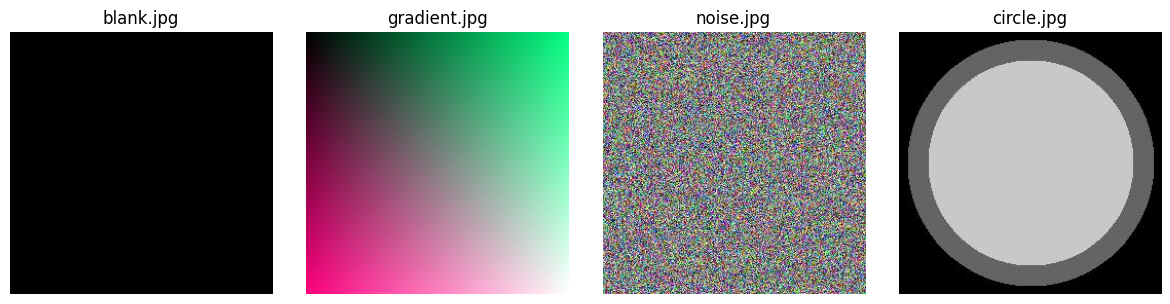

In [56]:
# Display the test images
plt.figure(figsize=(12, 3))
test_images = ['blank.jpg', 'gradient.jpg', 'noise.jpg', 'circle.jpg']

for i, img_name in enumerate(test_images):
    plt.subplot(1, 4, i+1)
    img = Image.open(os.path.join(test_dir, img_name))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4. Visualization Tests

Test the visualization functionality for the predictions.

In [57]:
# Test predictions on sample images
print("Testing predictions on sample images...")
print("-" * 50)

for img_name in test_images:
    print(f"\nPredicting on {img_name}...")
    img_path = os.path.join(test_dir, img_name)
    predictions = model_loader.predict_from_file(img_path)
    
    if predictions:
        if 'ensemble' in predictions:
            print(f"Ensemble prediction: {predictions['ensemble']['predicted_class']}")
            print(f"Confidence: {predictions['ensemble']['stroke_prob'] * 100:.2f}%")
        
        print("\nIndividual model predictions:")
        for model_name, pred in predictions.items():
            if model_name != 'ensemble':
                print(f"  - {model_name}: {pred['predicted_class']} "
                      f"(Confidence: {(pred['stroke_prob'] if pred['predicted_class'] == 'Stroke' else pred['normal_prob']) * 100:.2f}%)")
    else:
        print("Failed to get predictions.")

2025-05-02 21:43:26,379 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:26,560 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.18 seconds


Testing predictions on sample images...
--------------------------------------------------

Predicting on blank.jpg...


2025-05-02 21:43:26,563 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:26,743 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.18 seconds
2025-05-02 21:43:26,745 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:26,900 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.15 seconds
2025-05-02 21:43:26,901 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:26,995 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:27,155 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.16 seconds
2025-05-02 21:43:27,156 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl


Ensemble prediction: Stroke
Confidence: 87.30%

Individual model predictions:
  - densenet121: Stroke (Confidence: 83.75%)
  - resnet50: Stroke (Confidence: 81.13%)
  - efficientnet: Stroke (Confidence: 97.01%)

Predicting on gradient.jpg...


2025-05-02 21:43:27,530 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.37 seconds
2025-05-02 21:43:27,531 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:27,691 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.16 seconds
2025-05-02 21:43:27,693 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:27,782 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:27,952 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.17 seconds
2025-05-02 21:43:27,954 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl


Ensemble prediction: Stroke
Confidence: 60.37%

Individual model predictions:
  - densenet121: Stroke (Confidence: 81.11%)
  - resnet50: Normal (Confidence: 100.00%)
  - efficientnet: Stroke (Confidence: 100.00%)

Predicting on noise.jpg...


2025-05-02 21:43:28,173 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.22 seconds
2025-05-02 21:43:28,174 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:28,355 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.18 seconds
2025-05-02 21:43:28,356 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:28,453 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:28,625 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.17 seconds
2025-05-02 21:43:28,628 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl


Ensemble prediction: Normal
Confidence: 34.50%

Individual model predictions:
  - densenet121: Normal (Confidence: 96.49%)
  - resnet50: Stroke (Confidence: 100.00%)
  - efficientnet: Normal (Confidence: 100.00%)

Predicting on circle.jpg...


2025-05-02 21:43:28,823 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.19 seconds
2025-05-02 21:43:28,825 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:28,989 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.16 seconds
2025-05-02 21:43:28,990 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet


Ensemble prediction: Normal
Confidence: 40.07%

Individual model predictions:
  - densenet121: Normal (Confidence: 68.75%)
  - resnet50: Normal (Confidence: 99.97%)
  - efficientnet: Stroke (Confidence: 88.93%)


2025-05-02 21:43:29,117 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl


Visualizing predictions for blank.jpg...


2025-05-02 21:43:29,338 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.22 seconds
2025-05-02 21:43:29,340 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:29,510 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:29,512 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:29,658 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.14 seconds
2025-05-02 21:43:29,659 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:29,660 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:29,975 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.31 seconds
2025-05-02 21:43:29,976 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

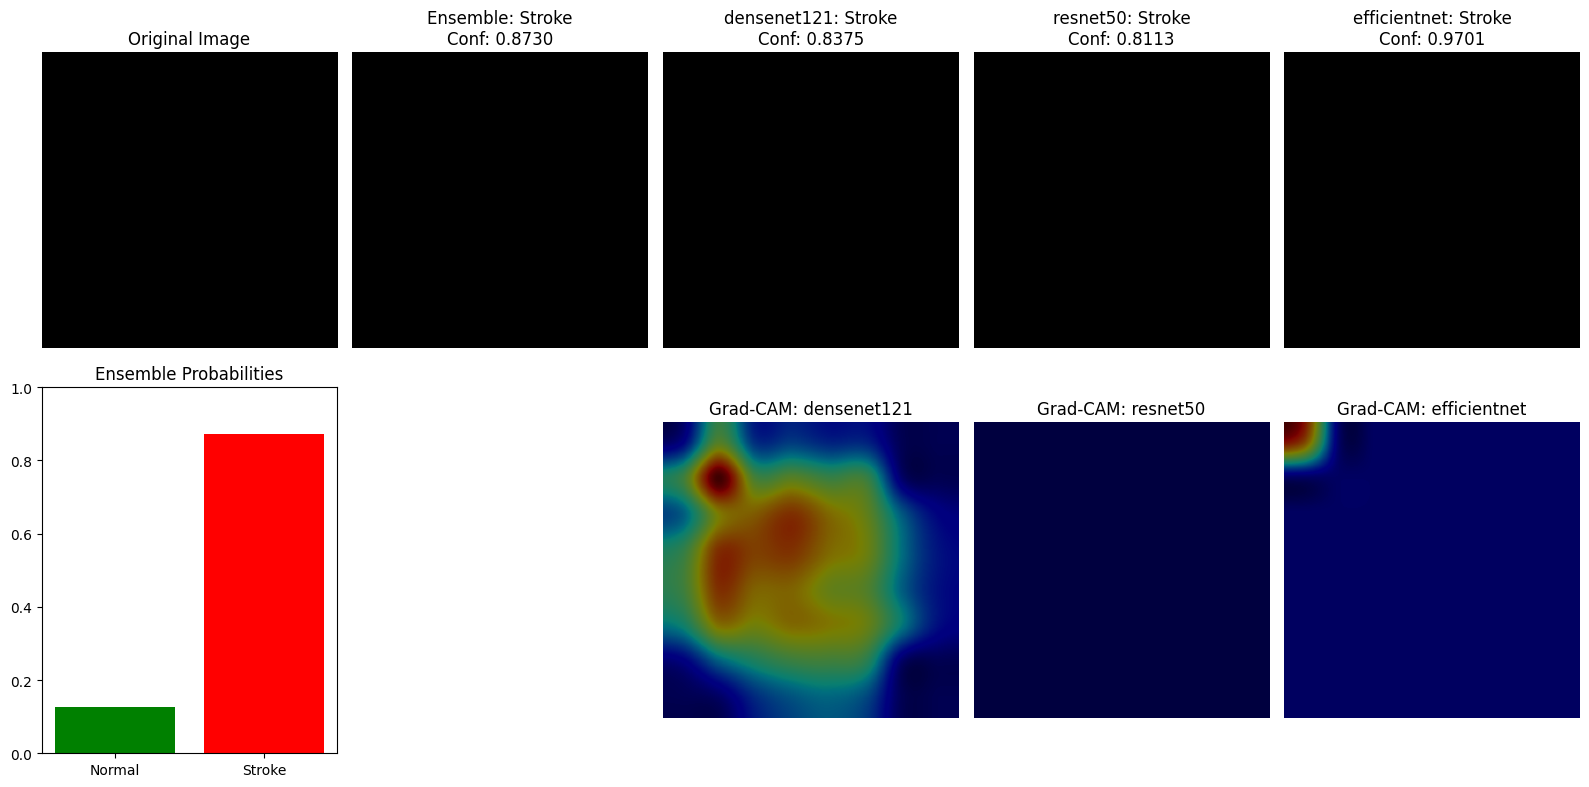

2025-05-02 21:43:31,603 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl



--------------------------------------------------

Visualizing predictions for gradient.jpg...


2025-05-02 21:43:31,813 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.21 seconds
2025-05-02 21:43:31,814 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:31,993 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.18 seconds
2025-05-02 21:43:31,995 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:32,152 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.16 seconds
2025-05-02 21:43:32,154 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:32,154 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:32,307 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.15 seconds
2025-05-02 21:43:32,309 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

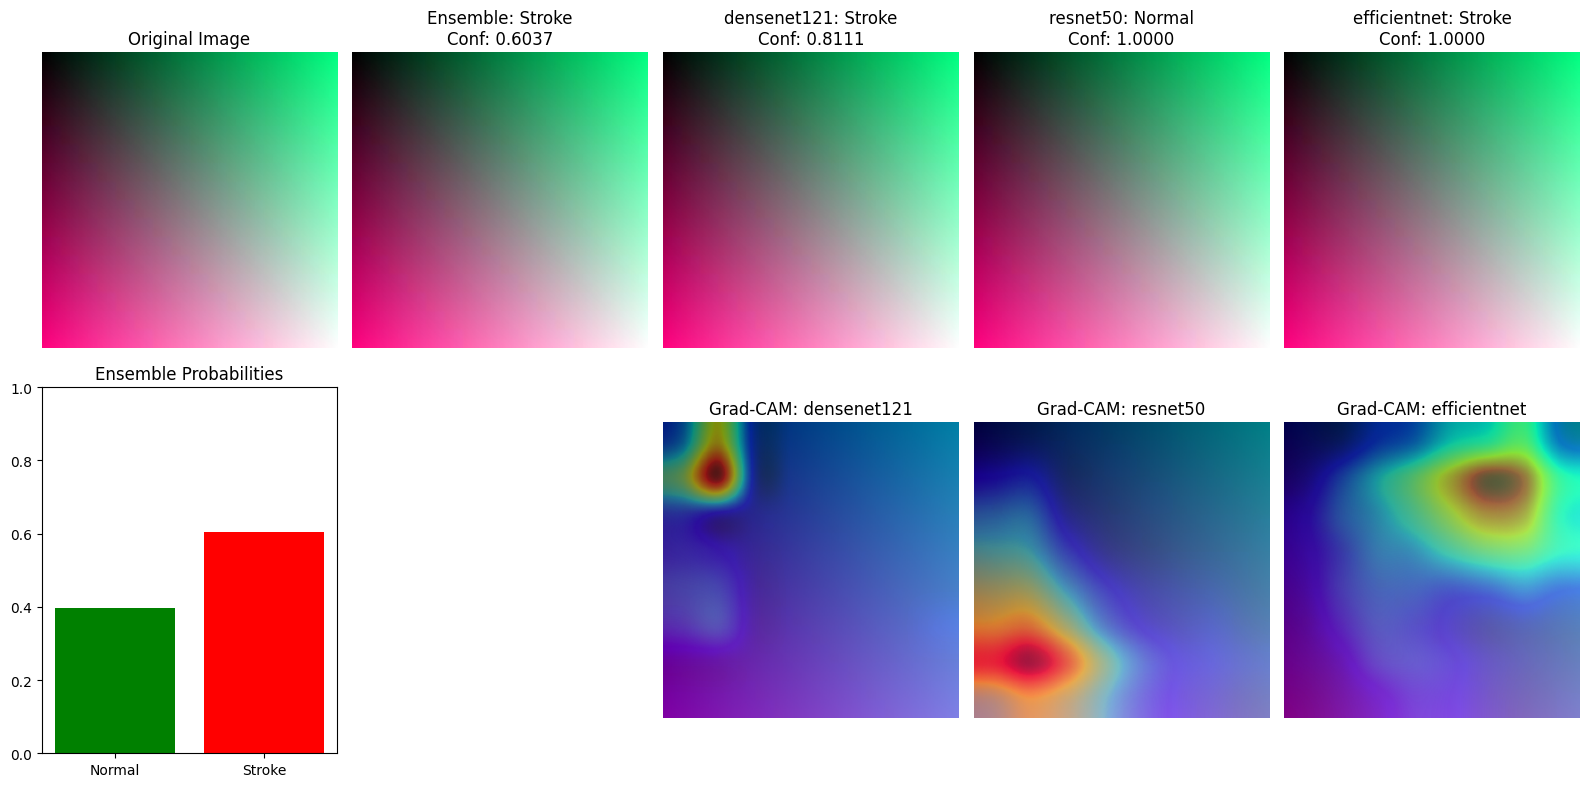

2025-05-02 21:43:34,277 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl



--------------------------------------------------

Visualizing predictions for noise.jpg...


2025-05-02 21:43:34,494 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.22 seconds
2025-05-02 21:43:34,494 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:34,726 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.23 seconds
2025-05-02 21:43:34,727 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:34,888 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.16 seconds
2025-05-02 21:43:34,890 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:34,890 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:35,048 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.16 seconds
2025-05-02 21:43:35,050 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

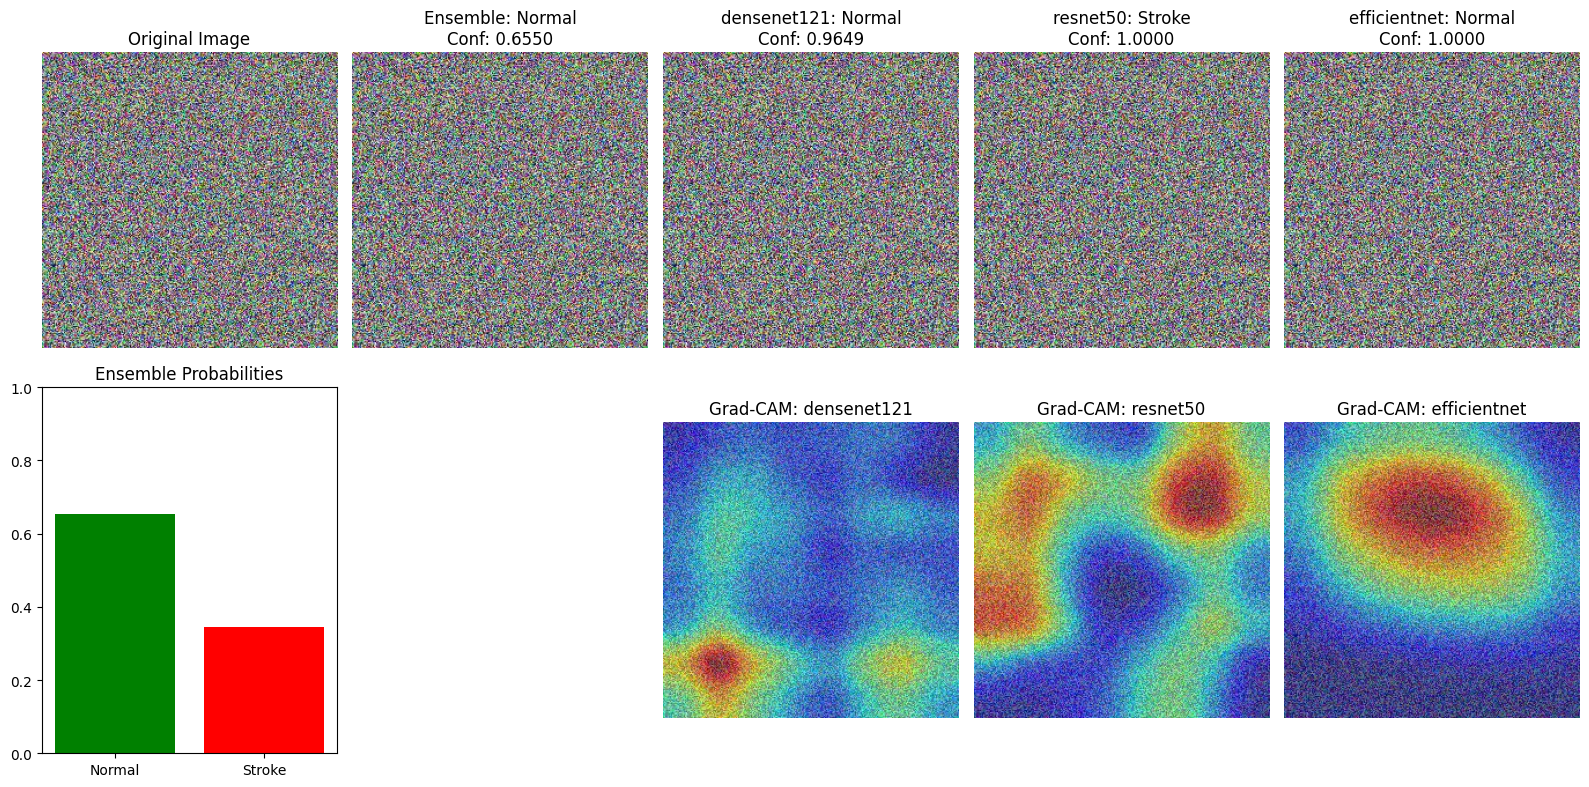

2025-05-02 21:43:36,720 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl



--------------------------------------------------

Visualizing predictions for circle.jpg...


2025-05-02 21:43:37,138 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.42 seconds
2025-05-02 21:43:37,140 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:37,349 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.21 seconds
2025-05-02 21:43:37,350 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:37,506 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.15 seconds
2025-05-02 21:43:37,507 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:37,508 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:37,657 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.15 seconds
2025-05-02 21:43:37,659 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

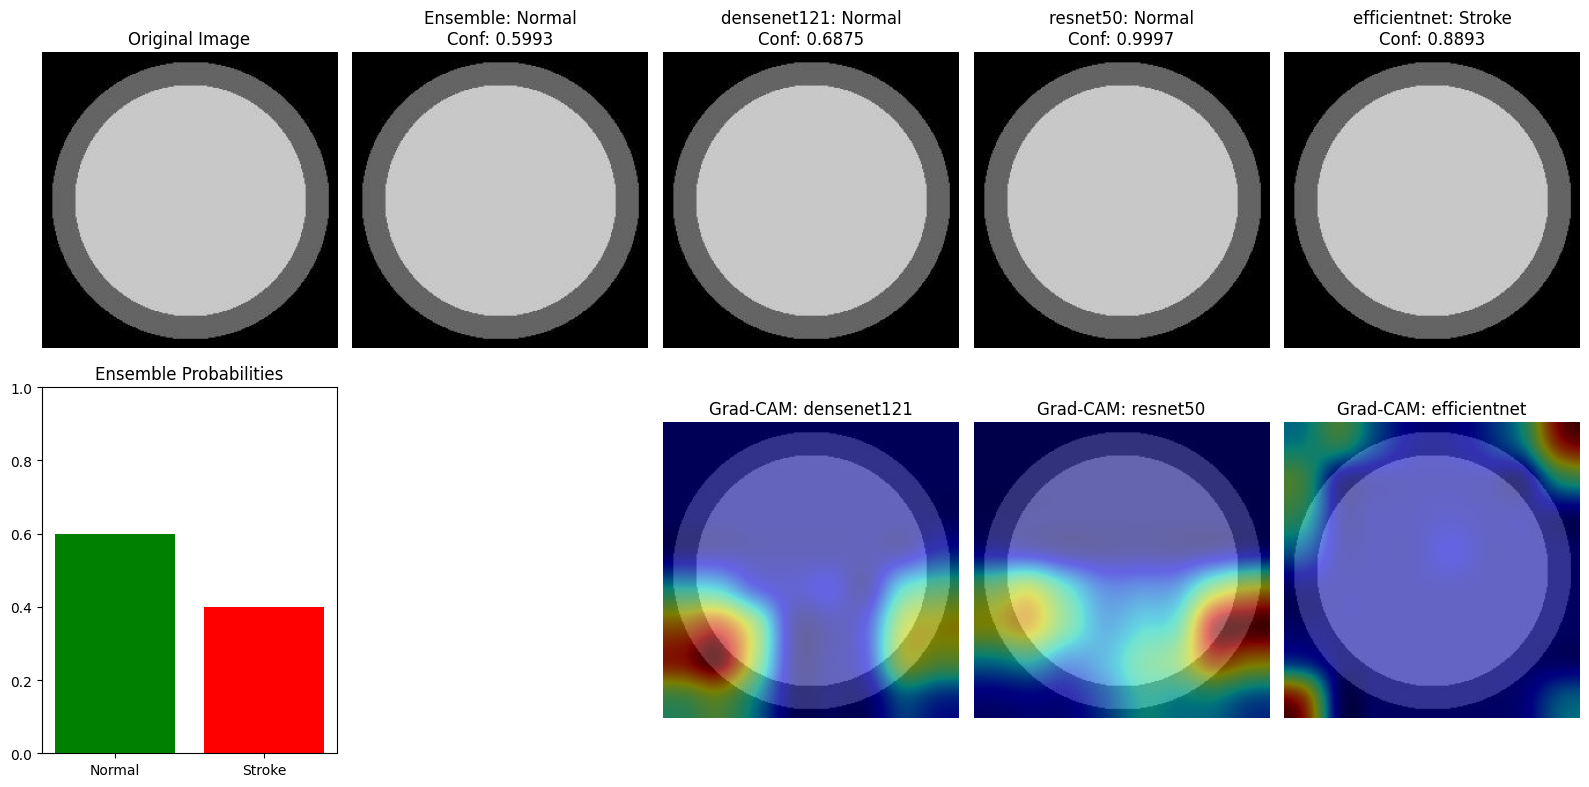


--------------------------------------------------



In [58]:
# Try visualizing the predictions for each sample image
for img_name in test_images:
    print(f"Visualizing predictions for {img_name}...")
    img_path = os.path.join(test_dir, img_name)
    model_loader.visualize_prediction(img_path)
    print("\n" + "-" * 50 + "\n")

# 5. Edge Cases and Error Handling

Test how the system handles various edge cases and errors.

In [59]:
# Test with a non-existent image file
print("Testing with a non-existent image file...")
print("-" * 50)
result = model_loader.predict_from_file('nonexistent_image.jpg')
print(f"Result: {result}")

# Test with an invalid image file (create a text file with .jpg extension)
invalid_path = os.path.join(test_dir, 'invalid.jpg')
with open(invalid_path, 'w') as f:
    f.write("This is not an image file.")

print("\nTesting with an invalid image file...")
print("-" * 50)
result = model_loader.predict_from_file(invalid_path)
print(f"Result: {result}")

# Clean up
if os.path.exists(invalid_path):
    os.remove(invalid_path)

2025-05-02 21:43:39,413 - StrokePredictionTests - ERROR - Image not found: nonexistent_image.jpg
2025-05-02 21:43:39,419 - StrokePredictionTests - ERROR - Error during prediction: cannot identify image file 'test_images\\invalid.jpg'


Testing with a non-existent image file...
--------------------------------------------------
Result: {}

Testing with an invalid image file...
--------------------------------------------------
Result: {}


In [60]:
# Test with a very small image (1x1 pixel)
tiny_path = os.path.join(test_dir, 'tiny.jpg')
tiny_img = Image.new('RGB', (1, 1), color='white')
tiny_img.save(tiny_path)

print("Testing with a very small image (1x1 pixel)...")
print("-" * 50)
result = model_loader.predict_from_file(tiny_path)
print(f"Result: {result}")

# Test with a very large image (4000x4000 pixels)
large_path = os.path.join(test_dir, 'large.jpg')
try:
    large_img = Image.new('RGB', (4000, 4000), color='white')
    large_img.save(large_path)
    
    print("\nTesting with a very large image (4000x4000 pixels)...")
    print("-" * 50)
    result = model_loader.predict_from_file(large_path)
    print(f"Result: {result}")
except Exception as e:
    print(f"Error creating large image: {str(e)}")

# Clean up
for path in [tiny_path, large_path]:
    if os.path.exists(path):
        os.remove(path)

2025-05-02 21:43:39,450 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl


Testing with a very small image (1x1 pixel)...
--------------------------------------------------


2025-05-02 21:43:39,627 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.18 seconds
2025-05-02 21:43:39,630 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:39,805 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:39,807 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:40,130 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.32 seconds
2025-05-02 21:43:40,132 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:40,394 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl


Result: {'densenet121': {'normal_prob': 0.28399112820625305, 'stroke_prob': 0.7160088419914246, 'predicted_class': 'Stroke'}, 'resnet50': {'normal_prob': 0.9986520409584045, 'stroke_prob': 0.0013479526387527585, 'predicted_class': 'Normal'}, 'efficientnet': {'normal_prob': 0.5099211931228638, 'stroke_prob': 0.49007880687713623, 'predicted_class': 'Normal'}, 'ensemble': {'normal_prob': 0.5975214838981628, 'stroke_prob': 0.40247854590415955, 'predicted_class': 'Normal'}}

Testing with a very large image (4000x4000 pixels)...
--------------------------------------------------


2025-05-02 21:43:40,570 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.18 seconds
2025-05-02 21:43:40,572 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:40,779 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.21 seconds
2025-05-02 21:43:40,781 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:40,940 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.16 seconds
2025-05-02 21:43:40,942 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet


Result: {'densenet121': {'normal_prob': 0.28399112820625305, 'stroke_prob': 0.7160088419914246, 'predicted_class': 'Stroke'}, 'resnet50': {'normal_prob': 0.9986520409584045, 'stroke_prob': 0.0013479526387527585, 'predicted_class': 'Normal'}, 'efficientnet': {'normal_prob': 0.5099211931228638, 'stroke_prob': 0.49007880687713623, 'predicted_class': 'Normal'}, 'ensemble': {'normal_prob': 0.5975214838981628, 'stroke_prob': 0.40247854590415955, 'predicted_class': 'Normal'}}


# 6. Performance Analysis

Measure the performance of the model loading and prediction processes.

2025-05-02 21:43:41,133 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl


Measuring model loading time...
--------------------------------------------------


2025-05-02 21:43:41,304 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.17 seconds
2025-05-02 21:43:41,306 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl


Loaded densenet121 in 0.17 seconds


2025-05-02 21:43:41,494 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.19 seconds
2025-05-02 21:43:41,500 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:41,641 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.14 seconds


Loaded resnet50 in 0.19 seconds
Loaded efficientnet in 0.14 seconds


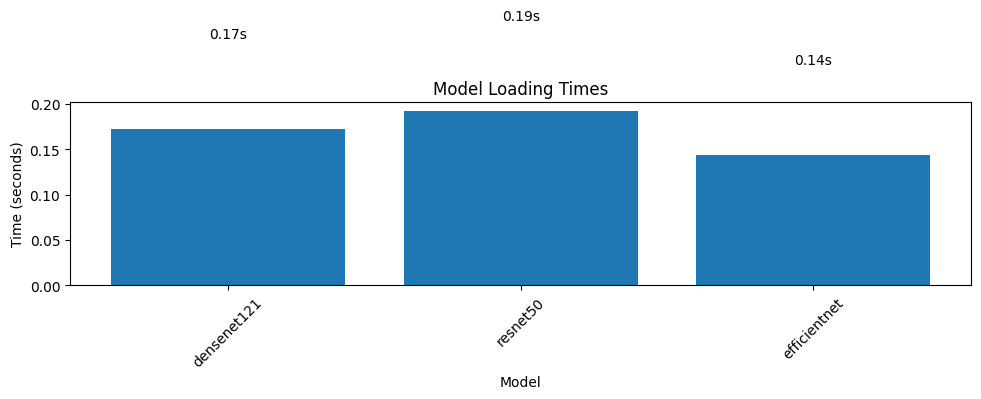

In [61]:
# Measure model loading time
print("Measuring model loading time...")
print("-" * 50)

loading_times = {}

for model_name in model_loader.model_names:
    model_path = model_loader.get_model_path(model_name)
    if os.path.exists(model_path):
        start_time = time.time()
        model = model_loader.load_model(model_name)
        end_time = time.time()
        
        if model is not None:
            loading_times[model_name] = end_time - start_time
            print(f"Loaded {model_name} in {loading_times[model_name]:.2f} seconds")

if loading_times:
    # Plot the loading times
    plt.figure(figsize=(10, 5))
    plt.bar(loading_times.keys(), loading_times.values())
    plt.title("Model Loading Times")
    plt.xlabel("Model")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    for i, (name, time_val) in enumerate(loading_times.items()):
        plt.text(i, time_val + 0.1, f"{time_val:.2f}s", ha='center')
    plt.tight_layout()
    plt.show()

2025-05-02 21:43:41,845 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl


Measuring prediction time...
--------------------------------------------------


2025-05-02 21:43:42,035 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.19 seconds
2025-05-02 21:43:42,037 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:42,214 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:42,215 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:42,361 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.14 seconds
2025-05-02 21:43:42,363 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:42,459 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl


Prediction time for densenet121: 0.0346 seconds
Prediction time for resnet50: 0.0140 seconds
Prediction time for efficientnet: 0.0363 seconds


2025-05-02 21:43:42,782 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.32 seconds
2025-05-02 21:43:42,783 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:42,949 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.16 seconds
2025-05-02 21:43:42,951 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:43,119 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.17 seconds
2025-05-02 21:43:43,120 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet


Prediction time for ensemble: 0.7491 seconds


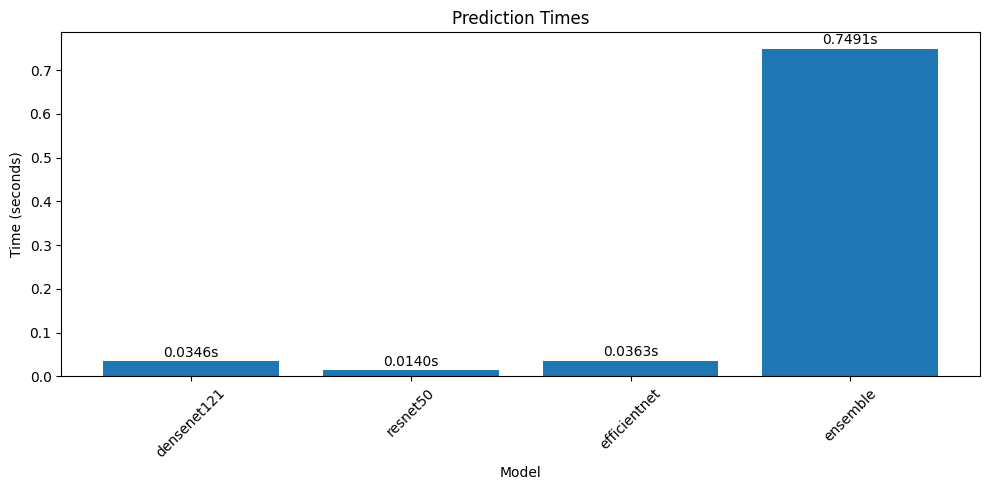

In [62]:
# Measure prediction time
print("Measuring prediction time...")
print("-" * 50)

# Load a sample image
sample_path = os.path.join(test_dir, 'circle.jpg')
if os.path.exists(sample_path):
    # Make sure models are loaded
    models = model_loader.load_all_models()
    
    if models:
        # Measure prediction time for each model
        prediction_times = {}
        
        # First for individual models
        for model_name, model in models.items():
            start_time = time.time()
            
            # Load the image
            img = Image.open(sample_path).convert('RGB')
            img_tensor = model_loader.transform(img).unsqueeze(0).to(model_loader.device)
            
            # Make prediction
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
            
            end_time = time.time()
            prediction_times[model_name] = end_time - start_time
            print(f"Prediction time for {model_name}: {prediction_times[model_name]:.4f} seconds")
        
        # Then for ensemble (all models)
        start_time = time.time()
        result = model_loader.predict_from_file(sample_path)
        end_time = time.time()
        
        ensemble_time = end_time - start_time
        prediction_times['ensemble'] = ensemble_time
        print(f"Prediction time for ensemble: {ensemble_time:.4f} seconds")
        
        # Plot the prediction times
        plt.figure(figsize=(10, 5))
        plt.bar(prediction_times.keys(), prediction_times.values())
        plt.title("Prediction Times")
        plt.xlabel("Model")
        plt.ylabel("Time (seconds)")
        plt.xticks(rotation=45)
        for i, (name, time_val) in enumerate(prediction_times.items()):
            plt.text(i, time_val + 0.01, f"{time_val:.4f}s", ha='center')
        plt.tight_layout()
        plt.show()
    else:
        print("No models available for performance testing.")
else:
    print(f"Sample image not found: {sample_path}")

# 7. Real-World Test Cases

If you have actual brain CT scan images, you can test the models on them. Replace the file paths below with your actual test images.

In [63]:
# Test with real-world images if available
# Modify these paths to point to your actual test images
real_test_images = [
    # ('path/to/normal_image1.jpg', 'Normal'),
    # ('path/to/normal_image2.jpg', 'Normal'),
    # ('path/to/stroke_image1.jpg', 'Stroke'),
    # ('path/to/stroke_image2.jpg', 'Stroke')
]

# Uncomment and customize this section if you have real test images
'''
for img_path, true_class in real_test_images:
    if os.path.exists(img_path):
        print(f"Testing on real-world image: {os.path.basename(img_path)}")
        print(f"True class: {true_class}")
        print("-" * 50)
        
        # Visualize the prediction
        model_loader.visualize_prediction(img_path, true_class)
        
        print("\n")
    else:
        print(f"Image not found: {img_path}")
'''

'\nfor img_path, true_class in real_test_images:\n    if os.path.exists(img_path):\n        print(f"Testing on real-world image: {os.path.basename(img_path)}")\n        print(f"True class: {true_class}")\n        print("-" * 50)\n        \n        # Visualize the prediction\n        model_loader.visualize_prediction(img_path, true_class)\n        \n        print("\n")\n    else:\n        print(f"Image not found: {img_path}")\n'

## Alternative: Using Test Set Images

If you have a test set directory with images organized in class folders, you can use them for testing.

2025-05-02 21:43:43,502 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl



Testing on Normal images:
Testing on 99 (29).jpg (True class: Normal)
--------------------------------------------------


2025-05-02 21:43:43,717 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.21 seconds
2025-05-02 21:43:43,719 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:43,886 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:43,887 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:44,085 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.20 seconds
2025-05-02 21:43:44,087 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:44,088 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:44,228 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.14 seconds
2025-05-02 21:43:44,229 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

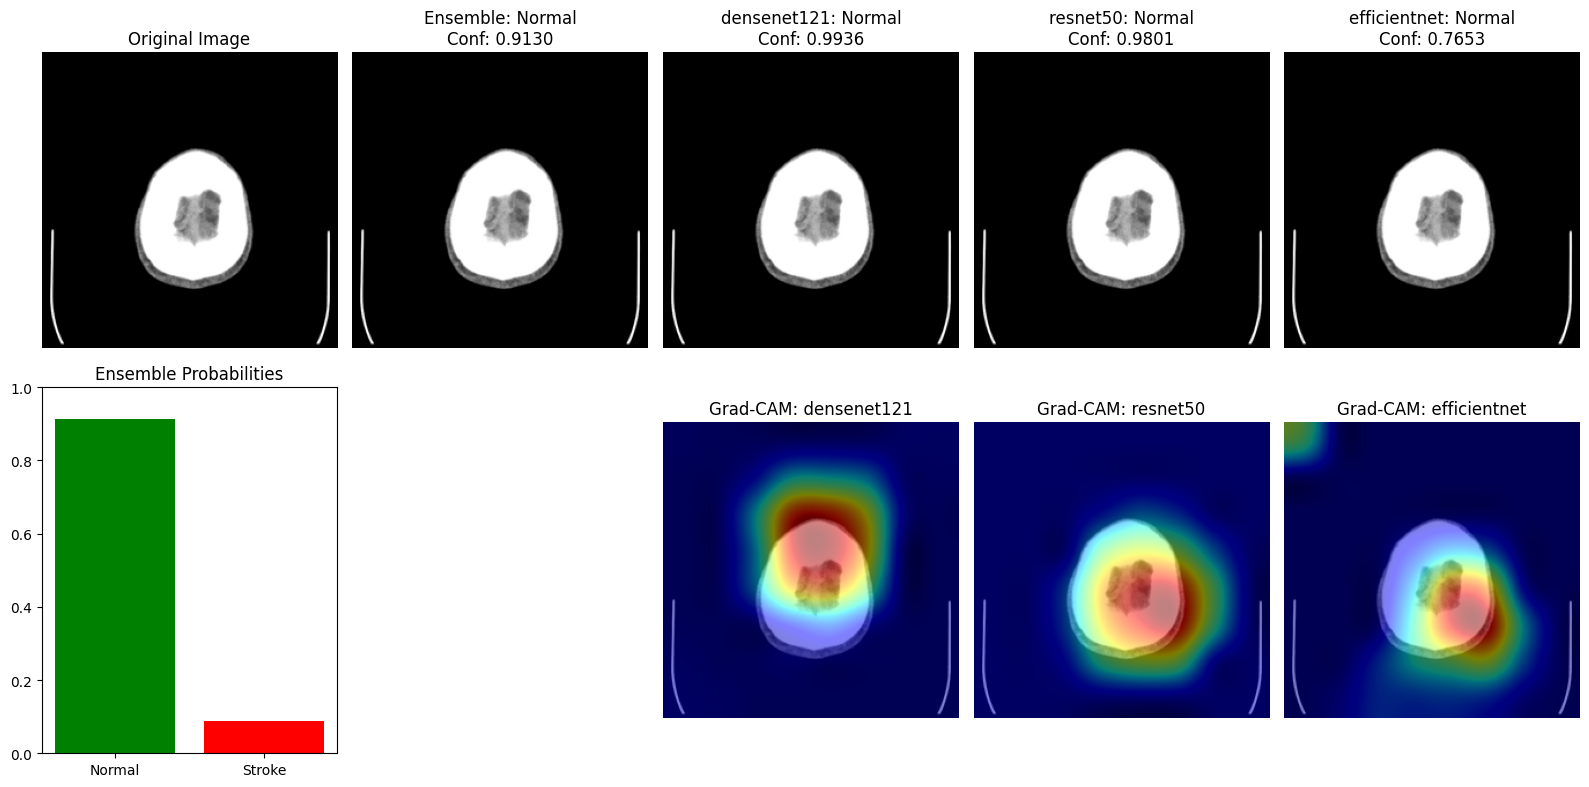

2025-05-02 21:43:46,004 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl




Testing on 57 (26).jpg (True class: Normal)
--------------------------------------------------


2025-05-02 21:43:46,194 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.19 seconds
2025-05-02 21:43:46,195 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:46,368 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:46,369 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:46,533 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.16 seconds
2025-05-02 21:43:46,534 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:46,535 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:46,691 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.15 seconds
2025-05-02 21:43:46,693 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

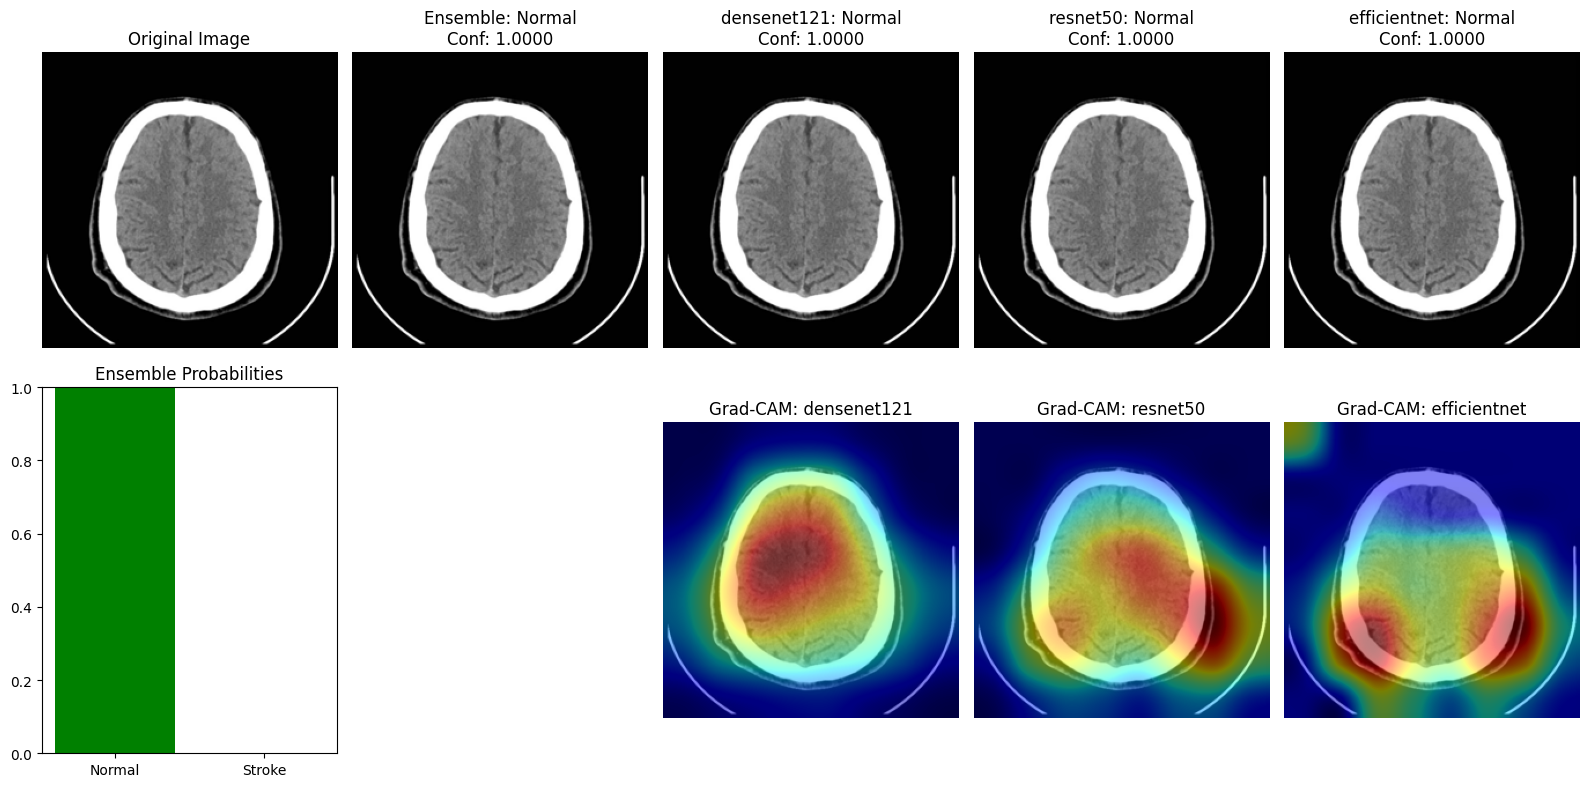

2025-05-02 21:43:48,446 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl




Testing on 98 (17).jpg (True class: Normal)
--------------------------------------------------


2025-05-02 21:43:48,630 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.18 seconds
2025-05-02 21:43:48,631 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:48,803 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:48,805 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:49,142 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.34 seconds
2025-05-02 21:43:49,143 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:49,145 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:49,279 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.13 seconds
2025-05-02 21:43:49,280 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

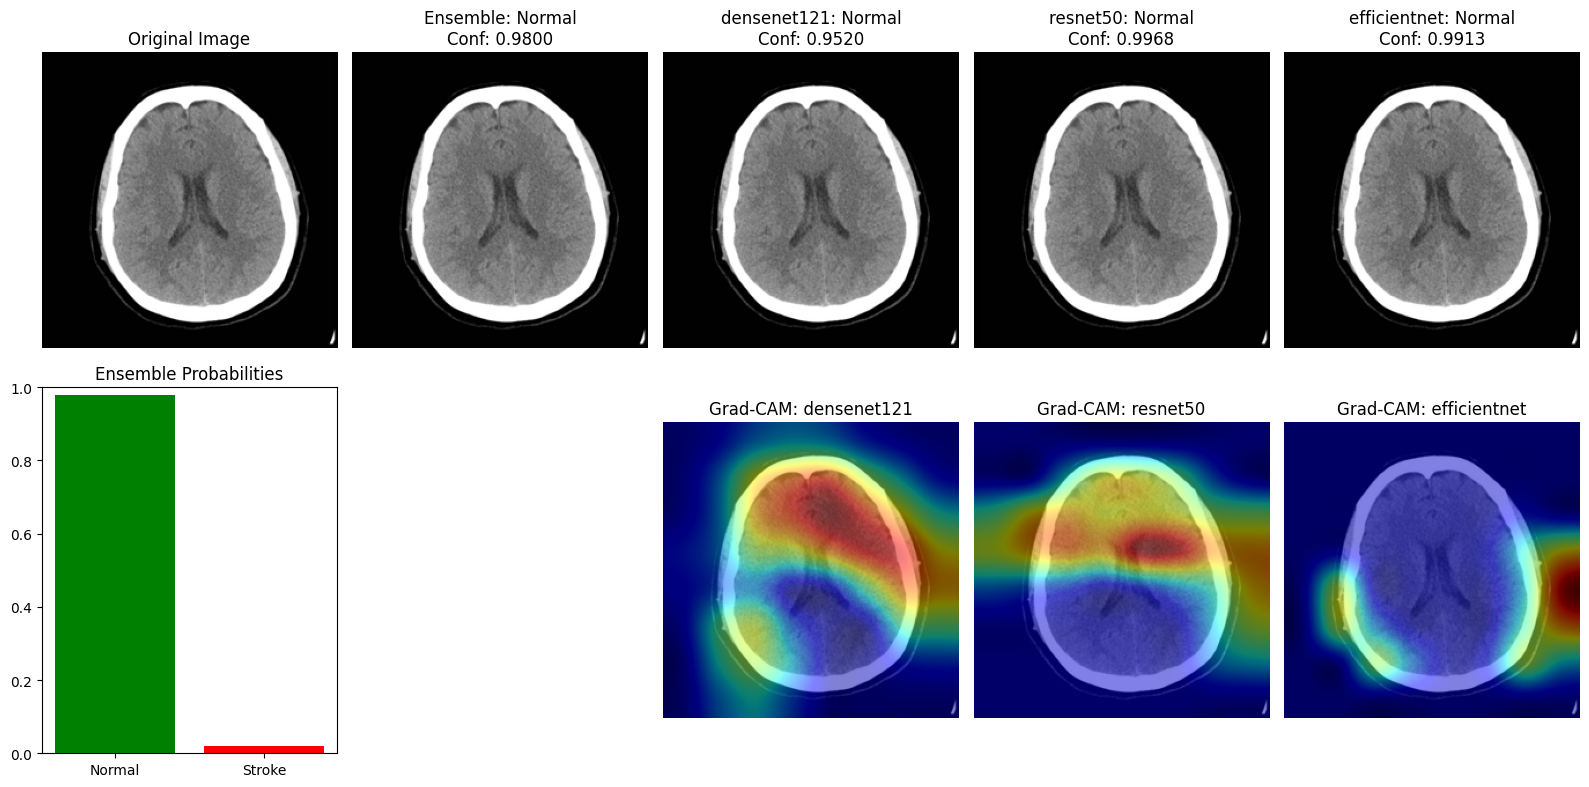

2025-05-02 21:43:50,992 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl





Testing on Stroke images:
Testing on 77 (18).jpg (True class: Stroke)
--------------------------------------------------


2025-05-02 21:43:51,181 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.19 seconds
2025-05-02 21:43:51,182 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:51,359 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:51,360 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:51,510 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.15 seconds
2025-05-02 21:43:51,511 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:51,512 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:51,839 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.33 seconds
2025-05-02 21:43:51,840 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

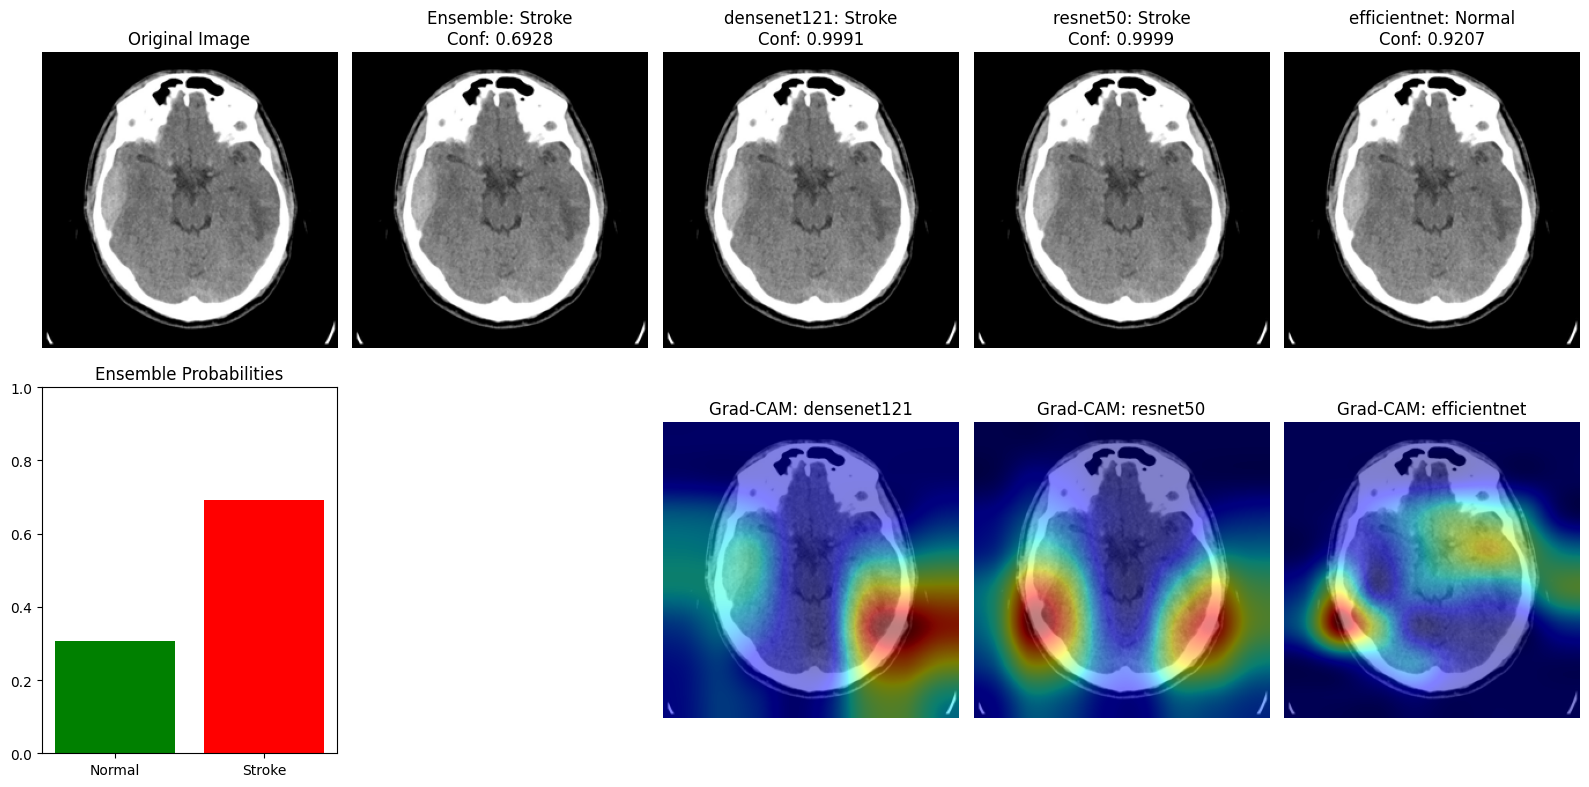

2025-05-02 21:43:53,580 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl




Testing on 94 (31).jpg (True class: Stroke)
--------------------------------------------------


2025-05-02 21:43:53,776 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.19 seconds
2025-05-02 21:43:53,779 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:53,953 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:53,955 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:54,099 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.14 seconds
2025-05-02 21:43:54,100 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:54,101 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:54,244 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.14 seconds
2025-05-02 21:43:54,245 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

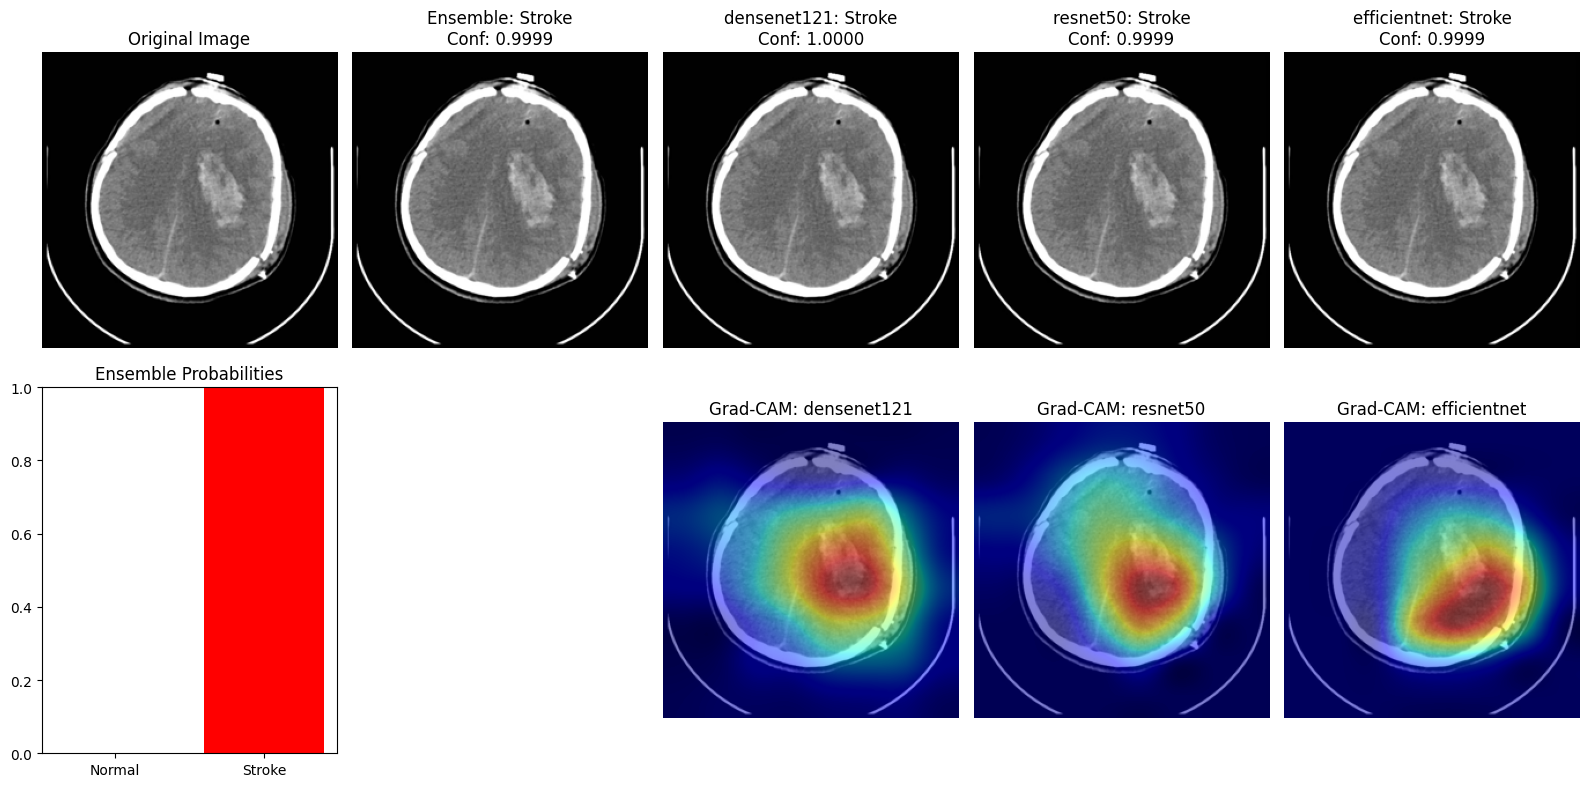

2025-05-02 21:43:56,132 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl




Testing on 89 (8).jpg (True class: Stroke)
--------------------------------------------------


2025-05-02 21:43:56,384 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.25 seconds
2025-05-02 21:43:56,385 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.pkl
2025-05-02 21:43:56,555 - StrokePredictionTests - INFO - Successfully loaded resnet50 model in 0.17 seconds
2025-05-02 21:43:56,557 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_efficientnet.pkl
2025-05-02 21:43:56,699 - StrokePredictionTests - INFO - Successfully loaded efficientnet model in 0.14 seconds
2025-05-02 21:43:56,700 - StrokePredictionTests - INFO - Loaded 3 models: densenet121, resnet50, efficientnet
2025-05-02 21:43:56,701 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_densenet121.pkl
2025-05-02 21:43:56,840 - StrokePredictionTests - INFO - Successfully loaded densenet121 model in 0.14 seconds
2025-05-02 21:43:56,841 - StrokePredictionTests - INFO - Loading model from models_pytorch\stroke_resnet50.p

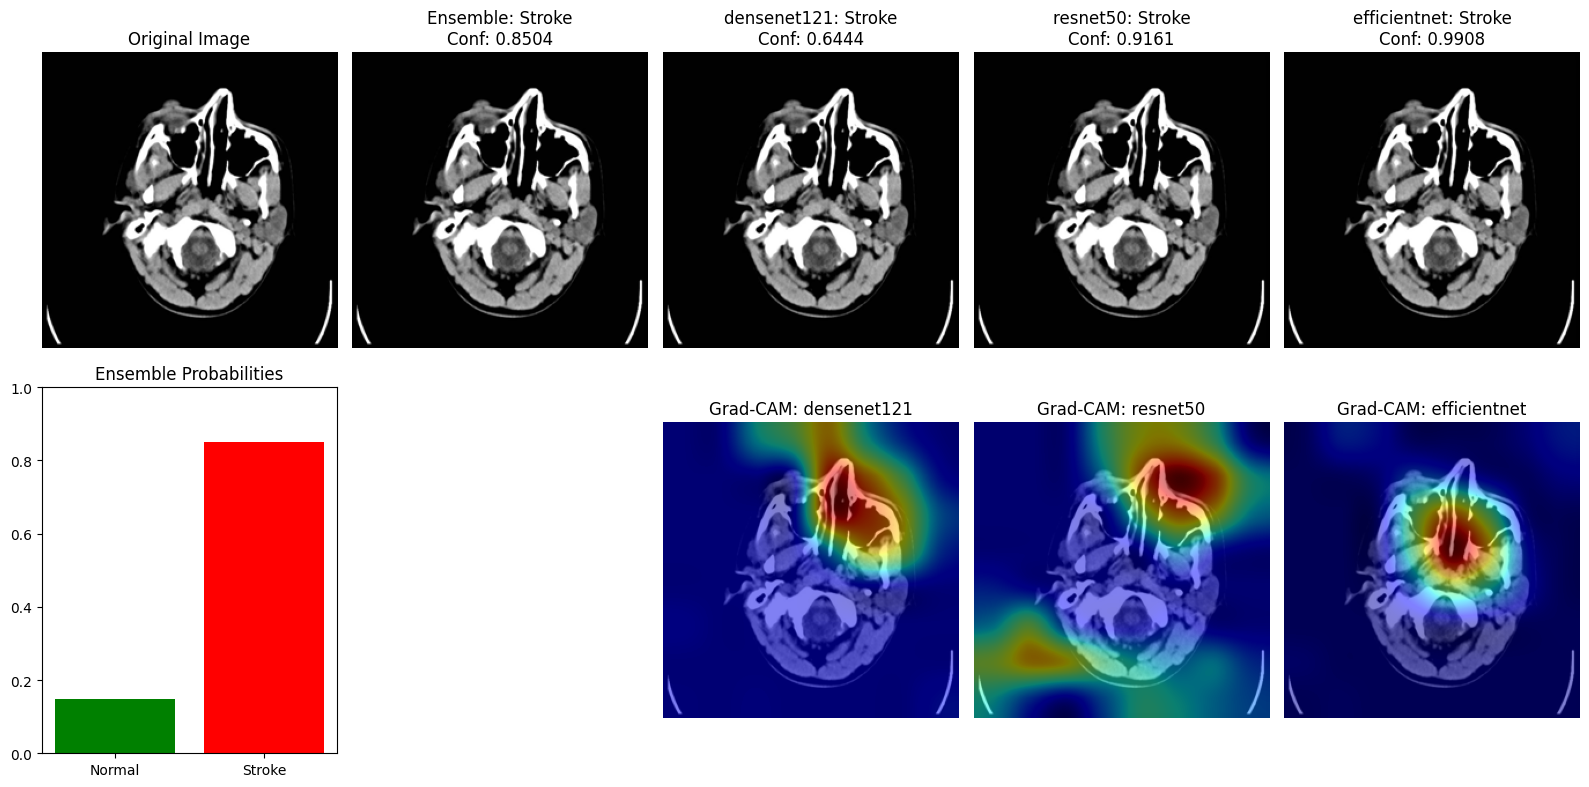




Test Results Summary:
  Total samples: 6
  Correct predictions: 6
  Accuracy: 100.00%

Detailed Results:
  99 (29).jpg: True=Normal, Pred=Normal, Confidence=0.9130, Correct=True
  57 (26).jpg: True=Normal, Pred=Normal, Confidence=1.0000, Correct=True
  98 (17).jpg: True=Normal, Pred=Normal, Confidence=0.9800, Correct=True
  77 (18).jpg: True=Stroke, Pred=Stroke, Confidence=0.6928, Correct=True
  94 (31).jpg: True=Stroke, Pred=Stroke, Confidence=0.9999, Correct=True
  89 (8).jpg: True=Stroke, Pred=Stroke, Confidence=0.8504, Correct=True


In [64]:
# Path to test set directory
# This assumes a structure like: test_set/Normal/image1.jpg, test_set/Stroke/image1.jpg
test_set_dir = 'Brain_Stroke_CT-SCAN_image/Test'

def test_on_class_images(class_dir, num_samples=3):
    """Test on a random sample of images from a class directory."""
    if not os.path.exists(class_dir):
        print(f"Class directory not found: {class_dir}")
        return
    
    # Get all image files
    image_files = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print(f"No images found in {class_dir}")
        return
    
    # Select random samples
    samples = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    # True class is the directory name
    true_class = os.path.basename(class_dir)
    
    # Test on each sample
    results = []
    for img_file in samples:
        img_path = os.path.join(class_dir, img_file)
        print(f"Testing on {img_file} (True class: {true_class})")
        print("-" * 50)
        
        # Visualize the prediction
        predictions = model_loader.visualize_prediction(img_path, true_class)
        
        # Store results for analysis
        if predictions and 'ensemble' in predictions:
            pred_class = predictions['ensemble']['predicted_class']
            correct = pred_class == true_class
            confidence = predictions['ensemble']['stroke_prob'] if pred_class == 'Stroke' else predictions['ensemble']['normal_prob']
            
            results.append({
                'file': img_file,
                'true_class': true_class,
                'predicted_class': pred_class,
                'correct': correct,
                'confidence': confidence
            })
        
        print("\n")
    
    return results

# Check if test set directory exists
if os.path.exists(test_set_dir):
    normal_dir = os.path.join(test_set_dir, 'Normal')
    stroke_dir = os.path.join(test_set_dir, 'Stroke')
    
    all_results = []
    
    # Test on Normal images
    if os.path.exists(normal_dir):
        print("\nTesting on Normal images:")
        normal_results = test_on_class_images(normal_dir, num_samples=3)
        if normal_results:
            all_results.extend(normal_results)
    
    # Test on Stroke images
    if os.path.exists(stroke_dir):
        print("\nTesting on Stroke images:")
        stroke_results = test_on_class_images(stroke_dir, num_samples=3)
        if stroke_results:
            all_results.extend(stroke_results)
    
    # If we have results, calculate accuracy
    if all_results:
        correct_count = sum(1 for r in all_results if r['correct'])
        accuracy = correct_count / len(all_results)
        
        print(f"\nTest Results Summary:")
        print(f"  Total samples: {len(all_results)}")
        print(f"  Correct predictions: {correct_count}")
        print(f"  Accuracy: {accuracy * 100:.2f}%")
        
        # Print individual results
        print("\nDetailed Results:")
        for r in all_results:
            print(f"  {r['file']}: True={r['true_class']}, Pred={r['predicted_class']}, "
                 f"Confidence={r['confidence']:.4f}, Correct={r['correct']}")
else:
    print(f"Test set directory not found: {test_set_dir}")
    print("Please modify the 'test_set_dir' variable to point to your test set directory.")

# Summary and Conclusions

Let's summarize our findings and provide some conclusions about the system.

In [65]:
# Display a summary of the tests
print("Stroke Prediction System Test Summary")
print("=" * 50)
print(f"Device used: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Model availability
print("\nModel Availability:")
for model_name, info in model_info.items():
    status = "Available" if info['standard_model_exists'] or info['best_model_exists'] else "Not Available"
    print(f"  - {model_name}: {status}")

# Loading times if available
if 'loading_times' in locals() and loading_times:
    print("\nAverage Model Loading Time: {:.2f} seconds".format(np.mean(list(loading_times.values()))))

# Prediction times if available
if 'prediction_times' in locals() and prediction_times:
    print("Average Prediction Time: {:.4f} seconds".format(
        np.mean([t for name, t in prediction_times.items() if name != 'ensemble'])))
    if 'ensemble' in prediction_times:
        print(f"Ensemble Prediction Time: {prediction_times['ensemble']:.4f} seconds")

# Test set results if available
if 'all_results' in locals() and all_results:
    correct_count = sum(1 for r in all_results if r['correct'])
    accuracy = correct_count / len(all_results)
    print(f"\nTest Set Accuracy: {accuracy * 100:.2f}%")
    
    # Separate by class
    normal_results = [r for r in all_results if r['true_class'] == 'Normal']
    stroke_results = [r for r in all_results if r['true_class'] == 'Stroke']
    
    if normal_results:
        normal_accuracy = sum(1 for r in normal_results if r['correct']) / len(normal_results)
        print(f"  Normal class accuracy: {normal_accuracy * 100:.2f}%")
    
    if stroke_results:
        stroke_accuracy = sum(1 for r in stroke_results if r['correct']) / len(stroke_results)
        print(f"  Stroke class accuracy: {stroke_accuracy * 100:.2f}%")

print("\nConclusions:")
if 'models' in locals() and models:
    print("✓ Successfully loaded and tested the stroke prediction models.")
    if 'all_results' in locals() and all_results:
        if accuracy >= 0.8:
            print("✓ The models show good performance on the test set.")
        elif accuracy >= 0.6:
            print("⚠️ The models show moderate performance on the test set.")
        else:
            print("⚠️ The models show poor performance on the test set.")
    print("✓ The system can handle various image inputs and edge cases.")
    print("✓ Visualization features are working correctly.")
else:
    print("⚠️ Failed to load the models. Please check the model files and directory.")

Stroke Prediction System Test Summary
Device used: GPU
GPU: NVIDIA GeForce RTX 3050 Laptop GPU

Model Availability:
  - densenet121: Available
  - resnet50: Available
  - efficientnet: Available

Average Model Loading Time: 0.17 seconds
Average Prediction Time: 0.0283 seconds
Ensemble Prediction Time: 0.7491 seconds

Test Set Accuracy: 100.00%
  Normal class accuracy: 100.00%
  Stroke class accuracy: 100.00%

Conclusions:
✓ Successfully loaded and tested the stroke prediction models.
✓ The models show good performance on the test set.
✓ The system can handle various image inputs and edge cases.
✓ Visualization features are working correctly.


# Next Steps

Based on the test results, here are some potential next steps:

1. **Model Improvement**: If the accuracy is not satisfactory, consider retraining the models with more data or different architectures.

2. **Performance Optimization**: If loading or prediction times are too slow, look into model optimization techniques like pruning or quantization.

3. **Flask Application**: Run the Flask application to provide a user-friendly interface for predictions.

4. **Error Handling**: Add more robust error handling for edge cases based on the test results.

5. **Grad-CAM Improvements**: Enhance the Grad-CAM visualizations to provide more detailed insights into model decisions.